<a href="https://colab.research.google.com/github/nowheremanmail/ML/blob/master/pypthon_recomendador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install vowpalwabbit

     |████████████████████████████████| 3.1MB 2.8MB/s 
  Created wheel for vowpalwabbit: filename=vowpalwabbit-8.8.1-cp36-cp36m-linux_x86_64.whl size=1675346 sha256=e62c3442e25cd63c88f0f27a225b33ef212be98a3feab18ede8e0dfefbfd4b39
  Stored in directory: /root/.cache/pip/wheels/17/41/59/fbefa702042c4a9ca33a87c7a3f49328bdfc664dd56466561b
Successfully built vowpalwabbit


In [0]:
import pandas as pd
import sklearn as sk
import numpy as np
import random
import matplotlib.pyplot as plt
from vowpalwabbit import pyvw

In [0]:
model = pyvw.vw(quiet=True)

In [0]:
train_examples = [
  "0 | price:.23 sqft:.25 age:.05 2006",
  "1 | price:.18 sqft:.15 age:.35 1976",
  "0 | price:.53 sqft:.32 age:.87 1924",
]

for example in train_examples:
    model.learn(example)

In [0]:
test_example = "| price:.46 sqft:.4 age:.10 1924"

prediction = model.predict(test_example)
print(prediction)

0.0


In [0]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0






In [0]:

# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [0]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [0]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))









shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [0]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob


In [0]:


def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [0]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

In [0]:

def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

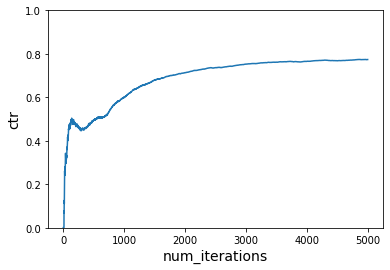

In [0]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

In [0]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [0]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

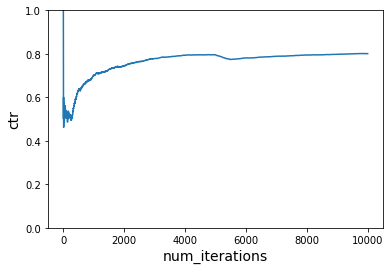

In [0]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

In [0]:
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

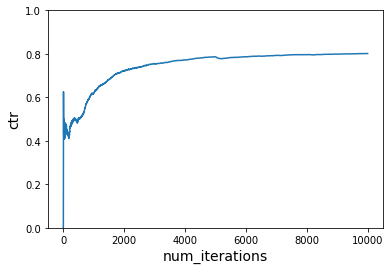

In [0]:
# use first reward function initially and then switch to third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)